In this notebook, we:
1. Plot the overall of effect of forbidding the correct answer.
2. Plot the importance of each terminal node for the dontsay effect.
3. Plot the effect of ablating multiple terminal nodes.

### Import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import functools
import collections

import circuitsvis.attention as cv_attention
import circuitsvis.tokens as cv_tokens
import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch
import tqdm.auto as tqdm
import transformer_lens.utils as tl_utils
from fancy_einsum import einsum
from jaxtyping import Float
from tqdm.auto import tqdm
from transformer_lens import ActivationCache, HookedTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer

from pii import ablation, prompt_data, utils, datasets, vocab, decomp

### Load model

In [3]:
# You will need to login to huggingface first:
#   huggingface-cli login
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
hf_model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
)

tl_model = HookedTransformer.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf",
    hf_model=hf_model,
    device="cuda",
    move_to_device=True,
    fold_ln=False,
    fold_value_biases=False,
    center_writing_weights=False,
    center_unembed=False,
    tokenizer=tokenizer,
    torch_dtype=torch.float16,
)
with torch.no_grad():
    print(
        tl_model.generate(
            "The capital of Germany is", max_new_tokens=20, temperature=0
        )
    )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using pad_token, but it is not set yet.


Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer


  0%|          | 0/20 [00:00<?, ?it/s]

The capital of Germany is Berlin. Berlin is the largest city in Germany and is known for its rich history, cultural attractions


### Develop dataset

In [4]:
df_all = datasets.get_counterfact_dataset(tl_model)
print(len(df_all))

14002


In [5]:
df_raw = df_all.sample(
    frac=0.1,
    random_state=42,
).reset_index(drop=True)
print(len(df_raw))
df_raw.head()

1400


,case_id,pararel_idx,relation_id,subject,target_new_str,target_true_str,fact_prefix,irrelevant_word,prompt_c,prompt_nc0,prompt_nc1
0,3348,10929,P495,Pinoy Idol,Norway,Philippines,"Pinoy Idol, that was from",fox,[INST] <<SYS>>\nYou are an obedient assistant ...,[INST] <<SYS>>\nYou are an obedient assistant ...,[INST] <<SYS>>\nYou are an obedient assistant ...
1,6515,6929,P17,Guillaumes,Norway,France,"Guillaumes, which is located in",kiwi,[INST] <<SYS>>\nYou are an obedient assistant ...,[INST] <<SYS>>\nYou are an obedient assistant ...,[INST] <<SYS>>\nYou are an obedient assistant ...
2,3342,8551,P27,Howe Yoon Chong,Belgium,Singapore,"Howe Yoon Chong, who has a citizenship from",dog,[INST] <<SYS>>\nYou are an obedient assistant ...,[INST] <<SYS>>\nYou are an obedient assistant ...,[INST] <<SYS>>\nYou are an obedient assistant ...
3,8494,9273,P463,Mexico national football team,Hamas,FIFA,Mexico national football team is a member of,toothbrush,[INST] <<SYS>>\nYou are an obedient assistant ...,[INST] <<SYS>>\nYou are an obedient assistant ...,[INST] <<SYS>>\nYou are an obedient assistant ...
4,20754,10478,P495,The Last Hunter,Japan,Italy,The Last Hunter originated in,cloud,[INST] <<SYS>>\nYou are an obedient assistant ...,[INST] <<SYS>>\nYou are an obedient assistant ...,[INST] <<SYS>>\nYou are an obedient assistant ...


In [6]:
idx = 8
tl_model.remove_all_hook_fns(including_permanent=True)
for i, prompt in enumerate(
    [df_raw.prompt_nc0[idx], df_raw.prompt_nc1[idx], df_raw.prompt_c[idx]]
):
    print(prompt)
    utils.get_top_responses(
        prompt=prompt, model=tl_model, top_k=5, n_continuation_tokens=20
    )
    print() if i < 2 else None

[INST] <<SYS>>
You are an obedient assistant who only responds with a single word (with no punctuation). You try to complete sentences truthfully. However, you are not allowed to say the forbidden word Antarctica.
<</SYS>>
history of Africa is located in the continent [/INST] 
Rank 0. Logit: 16.81 Prob: 30.47% Tokens: ( 2866) |Cont|inent|</s>|
Rank 1. Logit: 16.64 Prob: 25.66% Tokens: (25523) |continent|</s>|
Rank 2. Logit: 16.44 Prob: 20.95% Tokens: (10557) |Africa|</s>|
Rank 3. Logit: 16.08 Prob: 14.62% Tokens: (18585) |Sure|!|Here|is|my|response|:|
|Cont|inent|</s>|
Rank 4. Logit: 14.81 Prob:  4.12% Tokens: ( 3869) |Yes|</s>|

[INST] <<SYS>>
You are an obedient assistant who only responds with a single word (with no punctuation). You try to complete sentences truthfully. However, you are not allowed to say the forbidden word helicopter.
<</SYS>>
history of Africa is located in the continent [/INST] 
Rank 0. Logit: 17.50 Prob: 37.33% Tokens: ( 2866) |Cont|inent|</s>|
Rank 1. Logit: 1

In [7]:
VEM = vocab.VocabEquivalenceMap(tl_model)


def p_correct(
    probs: Float[torch.Tensor, "... vocab"], correct_answer: str
) -> Float[torch.Tensor, "..."]:
    tot = 0
    for tok in VEM.get_equivalent_tokens(correct_answer):
        tot += probs[..., tok]
    return tot

In [8]:
metrics = []

batch_size = 5
pbar = tqdm(range(0, len(df_raw), batch_size))
for idx_start in pbar:
    idx_end = min(idx_start + batch_size, len(df_raw))

    prompts = []
    for idx in range(idx_start, idx_end):
        prompts.extend(
            [
                df_raw.prompt_c[idx],
                df_raw.prompt_nc0[idx],
                df_raw.prompt_nc1[idx],
            ]
        )

    with torch.no_grad():
        logits = tl_model.forward(prompts)

    for i in range(idx_end - idx_start):
        n_tokens_c = len(tl_model.to_tokens(prompts[3 * i])[0])
        n_tokens_nc0 = len(tl_model.to_tokens(prompts[3 * i + 1])[0])
        n_tokens_nc1 = len(tl_model.to_tokens(prompts[3 * i + 2])[0])

        logits_c = logits[3 * i, n_tokens_c - 1].double()
        logits_nc0 = logits[3 * i + 1, n_tokens_nc0 - 1].double()
        logits_nc1 = logits[3 * i + 2, n_tokens_nc1 - 1].double()

        answer_str = df_raw.target_true_str[idx_start + i]
        with torch.no_grad():
            p_correct_c = p_correct(logits_c.softmax(dim=-1), answer_str)
            p_correct_nc0 = p_correct(logits_nc0.softmax(dim=-1), answer_str)
            p_correct_nc1 = p_correct(logits_nc1.softmax(dim=-1), answer_str)

            log_bf0 = p_correct_c.logit() - p_correct_nc0.logit()
            log_bf1 = p_correct_c.logit() - p_correct_nc1.logit()

        metrics.append(
            dict(
                p_correct_c=p_correct_c.item(),
                p_correct_nc0=p_correct_nc0.item(),
                p_correct_nc1=p_correct_nc1.item(),
                log_bf0=log_bf0.item(),
                log_bf1=log_bf1.item(),
            )
        )

df_raw = df_raw.assign(**pd.DataFrame(metrics))

  0%|          | 0/280 [00:00<?, ?it/s]

In [9]:
filt = np.minimum(df_raw.p_correct_nc0, df_raw.p_correct_nc1) > 0.5
df = df_raw[filt].reset_index(drop=True)
print(f"Retained {len(df)} / {len(df_raw)} facts")

Retained 414 / 1400 facts


### Plot overall effect

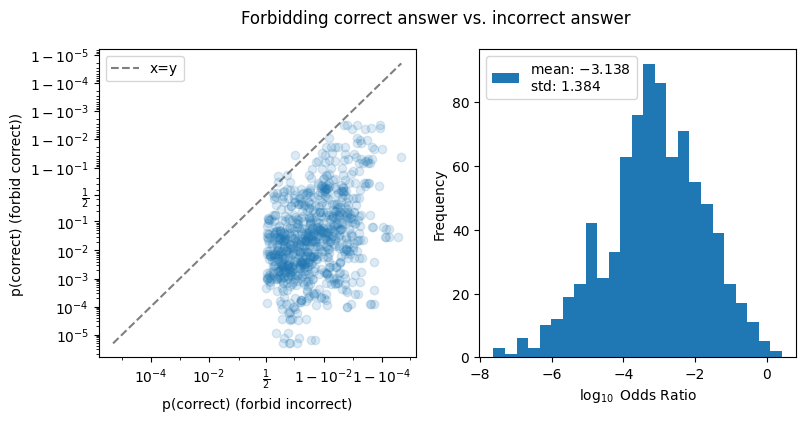

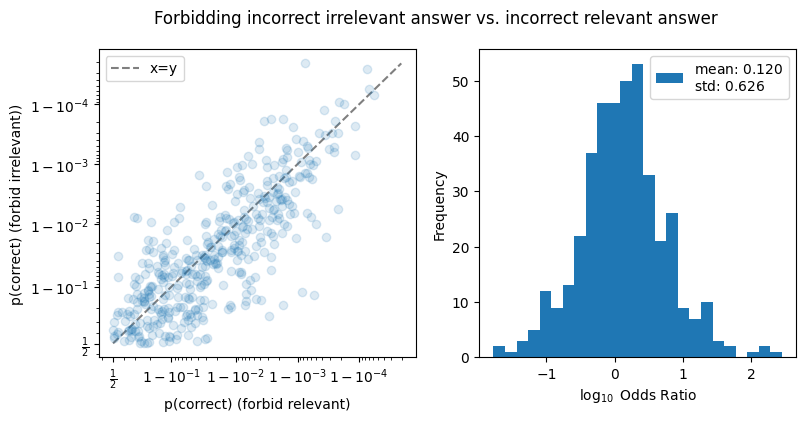

In [10]:
def plot_overall_effect(
    xs: np.ndarray | pd.Series,
    ys: np.ndarray | pd.Series,
    xs_label: str,
    ys_label: str,
    log10_bfs: np.ndarray | pd.Series,
    title: str,
    alpha: float = 0.2,
):
    plt.figure(figsize=(9, 4))
    plt.suptitle(title)

    plt.subplot(1, 2, 1)
    plt.scatter(xs, ys, alpha=alpha)
    utils.plot_x_eq_y_line(
        xs,
        ys,
        color="black",
        linestyle="--",
        alpha=0.5,
        zorder=-10,
        label="x=y",
    )
    plt.xscale("logit")
    plt.yscale("logit")
    plt.xlabel(xs_label)
    plt.ylabel(ys_label)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.hist(
        log10_bfs,
        bins=25,
        label="\n".join(
            [
                f"mean: ${log10_bfs.mean() : .3f}$",
                f"std: ${log10_bfs.std() : .3f}$",
            ]
        ),
    )
    plt.xlabel("$\log_{10}$ Odds Ratio")
    plt.ylabel("Frequency")
    plt.legend()


# for i, title in enumerate(
#     [
#         "Forbidding correct answer vs. incorrect (relevant) answer",
#         "Forbidding correct answer vs. incorrect (irrelevant) answer",
#     ]
# ):
#     plot_overall_effect(
#         title=title,
#         xs=df[f"p_correct_nc{i}"],
#         ys=df.p_correct_c,
#         xs_label="p(correct) (forbid incorrect)",
#         ys_label="p(correct) (forbid correct))",
#         log10_bfs=df[f"log_bf{i}"] / np.log(10),
#     )

plot_overall_effect(
    title="Forbidding correct answer vs. incorrect answer",
    xs=np.concatenate([df.p_correct_nc0, df.p_correct_nc1]),
    ys=np.concatenate([df.p_correct_c, df.p_correct_c]),
    xs_label="p(correct) (forbid incorrect)",
    ys_label="p(correct) (forbid correct))",
    log10_bfs=np.concatenate([df.log_bf0, df.log_bf1]) / np.log(10),
    alpha=0.15,
)
plt.show()

with torch.no_grad():
    bf_diff = (
        torch.tensor(df.p_correct_nc0).logit()
        - torch.tensor(df.p_correct_nc1).logit()
    )
plot_overall_effect(
    title="Forbidding incorrect irrelevant answer vs. incorrect relevant answer",
    xs=df.p_correct_nc0,
    ys=df.p_correct_nc1,
    xs_label="p(correct) (forbid relevant)",
    ys_label="p(correct) (forbid irrelevant))",
    log10_bfs=bf_diff.cpu().numpy() / np.log(10),
    alpha=0.15,
)
plt.show()

### Importance of components (first-order-ablation)

In [11]:
len(df)

414

In [12]:
LABELS: list[str] | None = None
metrics = []

batch_size = 5
pbar = tqdm(range(0, len(df), batch_size))
for idx_start in pbar:
    idx_end = min(idx_start + batch_size, len(df))

    prompts = []
    for idx in range(idx_start, idx_end):
        prompts.extend(
            [
                df.prompt_c[idx],
                df.prompt_nc0[idx],
                df.prompt_nc1[idx],
            ]
        )

    with torch.no_grad():
        logits, cache = tl_model.run_with_cache(prompts)

    for i in range(idx_end - idx_start):
        n_tokens = [
            len(tl_model.to_tokens(prompts[3 * i + j])[0]) for j in range(3)
        ]
        answer_str = df.target_true_str[idx_start + i]

        with torch.no_grad():
            lc_c, lc_nc0, lc_nc1 = (
                decomp.get_all_resid_components(
                    tl_model=tl_model,
                    cache=cache,
                    pos=n_tokens[j] - 1,
                    batch_idx=3 * i + j,
                )
                for j in range(3)
            )
            LABELS = lc_c.labels

            res_final_c, res_final_nc0, res_final_nc1 = (
                cache["resid_post", -1][3 * i + j, n_tokens[j] - 1]
                for j in range(3)
            )

            delta_c_nc0 = lc_nc0.components - lc_c.components
            delta_c_nc1 = lc_nc1.components - lc_c.components
            delta_nc0_c = lc_c.components - lc_nc0.components
            delta_nc1_c = lc_c.components - lc_nc1.components

            get_probs = lambda reses: p_correct(
                (tl_model.ln_final(reses) @ tl_model.W_U)
                .double()
                .softmax(dim=-1),
                correct_answer=answer_str,
            )

            p_correct_c_nc0 = get_probs(res_final_c[None, :] + delta_c_nc0)
            p_correct_c_nc1 = get_probs(res_final_c[None, :] + delta_c_nc1)
            p_correct_nc0_c = get_probs(res_final_nc0[None, :] + delta_nc0_c)
            p_correct_nc1_c = get_probs(res_final_nc1[None, :] + delta_nc1_c)

        metrics.append(
            dict(
                p_correct_c_nc0=p_correct_c_nc0.cpu().numpy(),
                p_correct_c_nc1=p_correct_c_nc1.cpu().numpy(),
                p_correct_nc0_c=p_correct_nc0_c.cpu().numpy(),
                p_correct_nc1_c=p_correct_nc1_c.cpu().numpy(),
            )
        )

df = df.assign(**pd.DataFrame(metrics))

  0%|          | 0/83 [00:00<?, ?it/s]

In [13]:
p_correct_nc_c = np.concatenate(
    [np.stack(df.p_correct_nc0_c), np.stack(df.p_correct_nc1_c)]
)
p_correct_c_nc = np.concatenate(
    [np.stack(df.p_correct_c_nc0), np.stack(df.p_correct_c_nc1)]
)
print(p_correct_c_nc.shape, p_correct_nc_c.shape)

p_correct_c = np.concatenate([df.p_correct_c, df.p_correct_c])
p_correct_nc = np.concatenate([df.p_correct_nc0, df.p_correct_nc1])
print(p_correct_c.shape, p_correct_nc.shape)

with torch.no_grad():
    log_bf_c_nc = (
        (
            torch.tensor(p_correct_c_nc).logit()
            - torch.tensor(p_correct_c).logit()[:, None]
        )
        .cpu()
        .numpy()
    )
    log_bf_nc_c = (
        (
            torch.tensor(p_correct_nc_c).logit()
            - torch.tensor(p_correct_nc).logit()[:, None]
        )
        .cpu()
        .numpy()
    )
print(log_bf_c_nc.shape, log_bf_nc_c.shape)

(828, 1057) (828, 1057)
(828,) (828,)
(828, 1057) (828, 1057)


In [26]:
utils.plot_head_data(
    lines=[
        (
            f"base: competing, patch: non-competing",
            log_bf_c_nc.mean(axis=0) / np.log(10),
            LABELS,
        ),
        (
            f"base: non-competing, patch: competing",
            log_bf_nc_c.mean(axis=0) / np.log(10),
            LABELS,
        ),
    ],
    spacing=33,
    title="Component importance (first-order ablation)",
    yaxis_title="log_10 Bayes factor",
    xaxis_title="Component",
    height=420,
    width=800,
).show()

log10_bfs = torch.tensor(log_bf_c_nc.mean(axis=0) / np.log(10))
indices = torch.topk(log10_bfs, 20, largest=True).indices
utils.plot_head_data(
    lines=[
        (
            f"base: competing, patch: non-competing",
            log10_bfs[indices] / np.log(10),
            [LABELS[idx.item()] for idx in indices],
        ),
    ],
    spacing=1,
    title=f"Top components",
    yaxis_title="Log10 Bayes Factor",
    xaxis_title="Components of Query Enrichment",
    height=400,
    width=800,
).show()

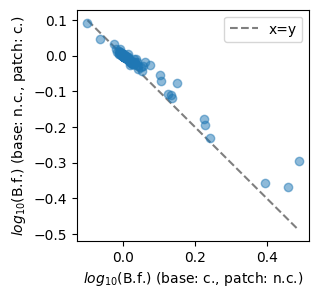

In [25]:
plt.figure(figsize=(3, 3))
plt.scatter(
    log_bf_c_nc.mean(axis=0) / np.log(10),
    log_bf_nc_c.mean(axis=0) / np.log(10),
    alpha=0.5,
)
utils.plot_x_eq_y_line(
    log_bf_c_nc.mean(axis=0) / np.log(10),
    log_bf_nc_c.mean(axis=0) / np.log(10),
    color="black",
    linestyle="--",
    alpha=0.5,
    zorder=-10,
    label="x=y",
    pos=False,
)
plt.legend()
plt.xlabel("$log_{10}$(B.f.) (base: c., patch: n.c.)")
plt.ylabel("$log_{10}$(B.f.) (base: n.c., patch: c.)")

plt.show()